In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
from pandas.io.formats.style import Styler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

import os
import sys
import datetime
from tqdm import tqdm
import math

import warnings; warnings.filterwarnings('ignore')

sys.path.append('..')
from config import CFG
CFG = CFG()
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', CFG.NCOLS)
pd.set_option('display.max_rows', CFG.NROWS)

In [4]:
from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
grn = Style.BRIGHT + Fore.GREEN
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

rc = {
    "axes.facecolor": "#FFFEF8",
    "figure.facecolor": "#FFFEF8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}
sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

In [12]:
orig = pd.read_csv(os.path.join(CFG.RAW_DATA, 'Pulsar.csv'))
train = pd.read_csv(os.path.join(CFG.RAW_DATA, 'train.csv')).drop(columns='id')
test = pd.read_csv(os.path.join(CFG.RAW_DATA, 'test.csv')).drop(columns='id')

In [13]:
print(f'{gld}[INFO] Shapes:'
      f'{gld}\n[+] origin ->  {red}{orig.shape}'
      f'{gld}\n[+] train  -> {red}{train.shape}'
      f'{gld}\n[+] test   ->  {red}{test.shape}\n')

print(f'{gld}[INFO] Any missing values:'
      f'{gld}\n[+] orig -> {red}{orig.isna().any().any()}'
      f'{gld}\n[+] train  -> {red}{train.isna().any().any()}'
      f'{gld}\n[+] test   -> {red}{test.isna().any().any()}')

[INFO] Shapes:
[+] origin ->  (17898, 9)
[+] train  -> (117564, 9)
[+] test   ->  (78377, 8)

[INFO] Any missing values:
[+] orig -> False
[+] train  -> False
[+] test   -> False


In [15]:
def magnify(is_test: bool = False):
        base_color = '#457ea5'
        if is_test:
                highlight_target_row = []
        else:
                highlight_target_row = [
                    dict(
                        selector='tr:last-child',
                        props=[('background-color', f'{base_color}20')],
                    )
                ]

        return [dict(selector="th",
                     props=[("font-size", "11pt"),
                            ('background-color', f'{base_color}'),
                            ('color', 'white'),
                            ('font-weight', 'bold'),
                            ('border-bottom', '0.1px solid white'),
                            ('border-left', '0.1px solid white'),
                            ('text-align', 'right')]),

                dict(selector='th.blank.level0', 
                    props=[('font-weight', 'bold'),
                           ('border-left', '1.7px solid white'),
                           ('background-color', 'white')]),

                dict(selector="td",
                     props=[('padding', "0.5em 1em"),
                            ('text-align', 'right')]),

                dict(selector="th:hover",
                     props=[("font-size", "14pt")]),

                dict(selector="tr:hover td:hover",
                     props=[('max-width', '250px'),
                            ('font-size', '14pt'),
                            ('color', f'{base_color}'),
                            ('font-weight', 'bold'),
                            ('background-color', 'white'),
                            ('border', f'1px dashed {base_color}')]),

                 dict(selector="caption",
                      props=[(('caption-side', 'bottom'))])] + highlight_target_row

def stylize_min_max_count(pivot_table):
    """Waps the min_max_count pivot_table into the Styler.

        Args:
            df: |min_train| max_train |min_test |max_test |top10_counts_train |top_10_counts_train|

        Returns:
            s: the dataframe wrapped into Styler.
    """
    s = pivot_table
    # A formatting dictionary for controlling each column precision (.000 <-). 
    di_frmt = {(i if i.startswith('m') else i):
              ('{:.3f}' if i.startswith('m') else '{:}') for i in s.columns}

    s = s.style.set_table_styles(magnify(True))\
        .format(di_frmt)\
        .set_caption("The train and test datasets min, max, top10 values side by side (hover to magnify).")
    return s

def stylize_describe(df: pd.DataFrame, dataset_name: str = 'train', is_test: bool = False) -> Styler:
    """Applies .descibe() method to the df and wraps it into the Styler.
    
        Args:
            df: any dataframe (train/test/origin)
            dataset_name: default 'train'
            is_test: the bool parameter passed into magnify() function
                     in order to control the highlighting of the last row.
                     
        Returns:
            s: the dataframe wrapped into Styler.
    """
    s = df.describe().T
    # A formatting dictionary for controlling each column precision (.000 <-). 
    di_frmt = {(i if i == 'count' else i):
              ('{:.0f}' if i == 'count' else '{:.3f}') for i in s.columns}
    
    s = s.style.set_table_styles(magnify(is_test))\
        .format(di_frmt)\
        .set_caption(f"The {dataset_name} dataset descriptive statistics (hover to magnify).")
    return s

def stylize_simple(df: pd.DataFrame, caption: str) -> Styler:
    """Waps the min_max_count pivot_table into the Styler.

        Args:
            df: any dataframe (train/test/origin)

        Returns:
            s: the dataframe wrapped into Styler.
    """
    s = df
    s = s.style.set_table_styles(magnify(True)).set_caption(f"{caption}")
    return s

In [16]:
display(stylize_simple(train.head(4), 'The train dataset 3 top rows (hover to magnify).'))
display(stylize_describe(train))
display(stylize_describe(test, 'test', is_test=True))

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0
2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0
3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899,0


,count,mean,std,min,25%,50%,75%,max
Mean_Integrated,117564,111.248,24.906,6.055,104.547,116.664,126.297,189.367
SD,117564,46.714,6.103,24.783,43.443,47.479,50.863,93.603
EK,117564,0.503,1.127,-1.731,0.050,0.186,0.396,7.880
Skewness,117564,1.886,6.515,-1.792,-0.189,0.092,0.692,65.386
Mean_DMSNR_Curve,117564,11.963,26.720,0.213,2.090,2.809,4.123,217.371
SD_DMSNR_Curve,117564,26.191,20.042,7.370,14.955,18.165,24.732,109.891
EK_DMSNR_Curve,117564,8.037,3.841,-2.598,6.743,8.443,10.003,34.540
Skewness_DMSNR_Curve,117564,93.881,79.962,-1.977,49.409,83.421,122.093,1191.001
Class,117564,0.093,0.291,0.000,0.000,0.000,0.000,1.000


,count,mean,std,min,25%,50%,75%,max
Mean_Integrated,78377,111.329,24.682,5.812,104.586,116.555,126.195,192.617
SD,78377,46.730,6.088,24.772,43.502,47.466,50.854,91.809
EK,78377,0.495,1.111,-1.788,0.050,0.185,0.395,8.070
Skewness,78377,1.834,6.401,-1.792,-0.190,0.091,0.692,64.117
Mean_DMSNR_Curve,78377,11.857,26.610,0.213,2.089,2.804,4.099,223.392
SD_DMSNR_Curve,78377,26.075,19.930,7.449,14.954,18.165,24.548,110.545
EK_DMSNR_Curve,78377,8.048,3.826,-2.557,6.756,8.444,9.973,31.472
Skewness_DMSNR_Curve,78377,94.034,79.906,-1.977,49.704,83.323,122.093,1072.793


# Min Max Counts

In [17]:
cm = sns.light_palette('#457ea5', as_cmap=True)

counts_tr = pd.Series({ft: [train[ft].value_counts().round(3).iloc[:5].to_dict()] for ft in train.columns}, name='top_5_counts_train')
counts_te = pd.Series({ft: [test[ft].value_counts().round(3).iloc[:5].to_dict()] for ft in test.columns}, name='top_5_counts_test')
nunique_tr = train.nunique().rename('nunique_train')
nunique_te = test.nunique().rename('nunique_test')
nunique_te['Class'] = 0

min_max = train.describe().T[['min', 'max']].add_suffix('_train').join(test.describe().T[['min', 'max']].add_suffix('_test'))
stats_pivot = pd.concat([min_max, nunique_tr, nunique_te, counts_tr, counts_te], axis=1)
stylize_min_max_count(stats_pivot).background_gradient(cm, subset=['min_test', 'min_train', 'max_train', 'max_test'])

,min_train,max_train,min_test,max_test,nunique_train,nunique_test,top_5_counts_train,top_5_counts_test
Mean_Integrated,6.055,189.367,5.812,192.617,11065,10063,"[{106.7109375: 127, 120.828125: 121, 123.828125: 113, 119.3046875: 111, 114.8125: 103}]","[{106.7109375: 93, 120.828125: 79, 114.8359375: 75, 123.5703125: 75, 123.828125: 74}]"
SD,24.783,93.603,24.772,91.809,49262,37058,"[{51.82915896: 73, 45.82762157: 59, 54.94868878: 57, 44.95531636: 54, 46.93619963: 53}]","[{51.82915896: 44, 48.91219013: 37, 46.93619963: 36, 54.94868878: 34, 45.82762157: 34}]"
EK,-1.731,7.880,-1.788,8.070,37132,28760,"[{0.527957554: 80, 0.262599764: 68, -0.049364179: 67, 0.034810744: 61, 0.339964064: 57}]","[{0.527957554: 50, 0.034810744: 44, 0.179841758: 43, 0.078459969: 39, 4.838103704: 39}]"
Skewness,-1.792,65.386,-1.792,64.117,41366,31604,"[{-0.374934811: 83, 0.099693988: 59, -0.07976327: 59, 0.039792179: 58, -0.253865826: 50}]","[{-0.07976327: 46, -0.259967627: 45, -0.171750769: 40, 0.764473291: 39, 0.039792179: 37}]"
Mean_DMSNR_Curve,0.213,217.371,0.213,223.392,12474,10851,"[{2.294314381: 225, 2.33277592: 224, 2.970735786: 223, 1.940635452: 220, 2.52090301: 206}]","[{2.33277592: 152, 2.970735786: 149, 1.940635452: 146, 2.943143813: 138, 2.52090301: 134}]"
SD_DMSNR_Curve,7.370,109.891,7.449,110.545,48050,36211,"[{16.76626465: 65, 14.83555934: 63, 13.82601301: 57, 17.89844422: 56, 14.72370745: 50}]","[{16.76626465: 52, 14.83555934: 50, 18.81215941: 39, 13.97951052: 37, 13.82601301: 36}]"
EK_DMSNR_Curve,-2.598,34.540,-2.557,31.472,42870,32807,"[{8.96401612: 73, 8.43257251: 64, 10.63844438: 61, 8.89029666: 59, 8.858354116: 59}]","[{8.43257251: 54, 8.96401612: 51, 10.83564068: 44, 8.979295493: 42, 8.099255716: 41}]"
Skewness_DMSNR_Curve,-1.977,1191.001,-1.977,1072.793,50648,37924,"[{-1.914087857: 85, 72.82662621: 54, 81.8654112: 49, 77.86910097: 44, -1.928211959: 43}]","[{-1.914087857: 67, -1.928211959: 35, 81.8654112: 35, 77.86910097: 31, -0.92402117: 31}]"
Class,0.000,1.000,nan,nan,2,0,"[{0: 106597, 1: 10967}]",nan


# Distributions

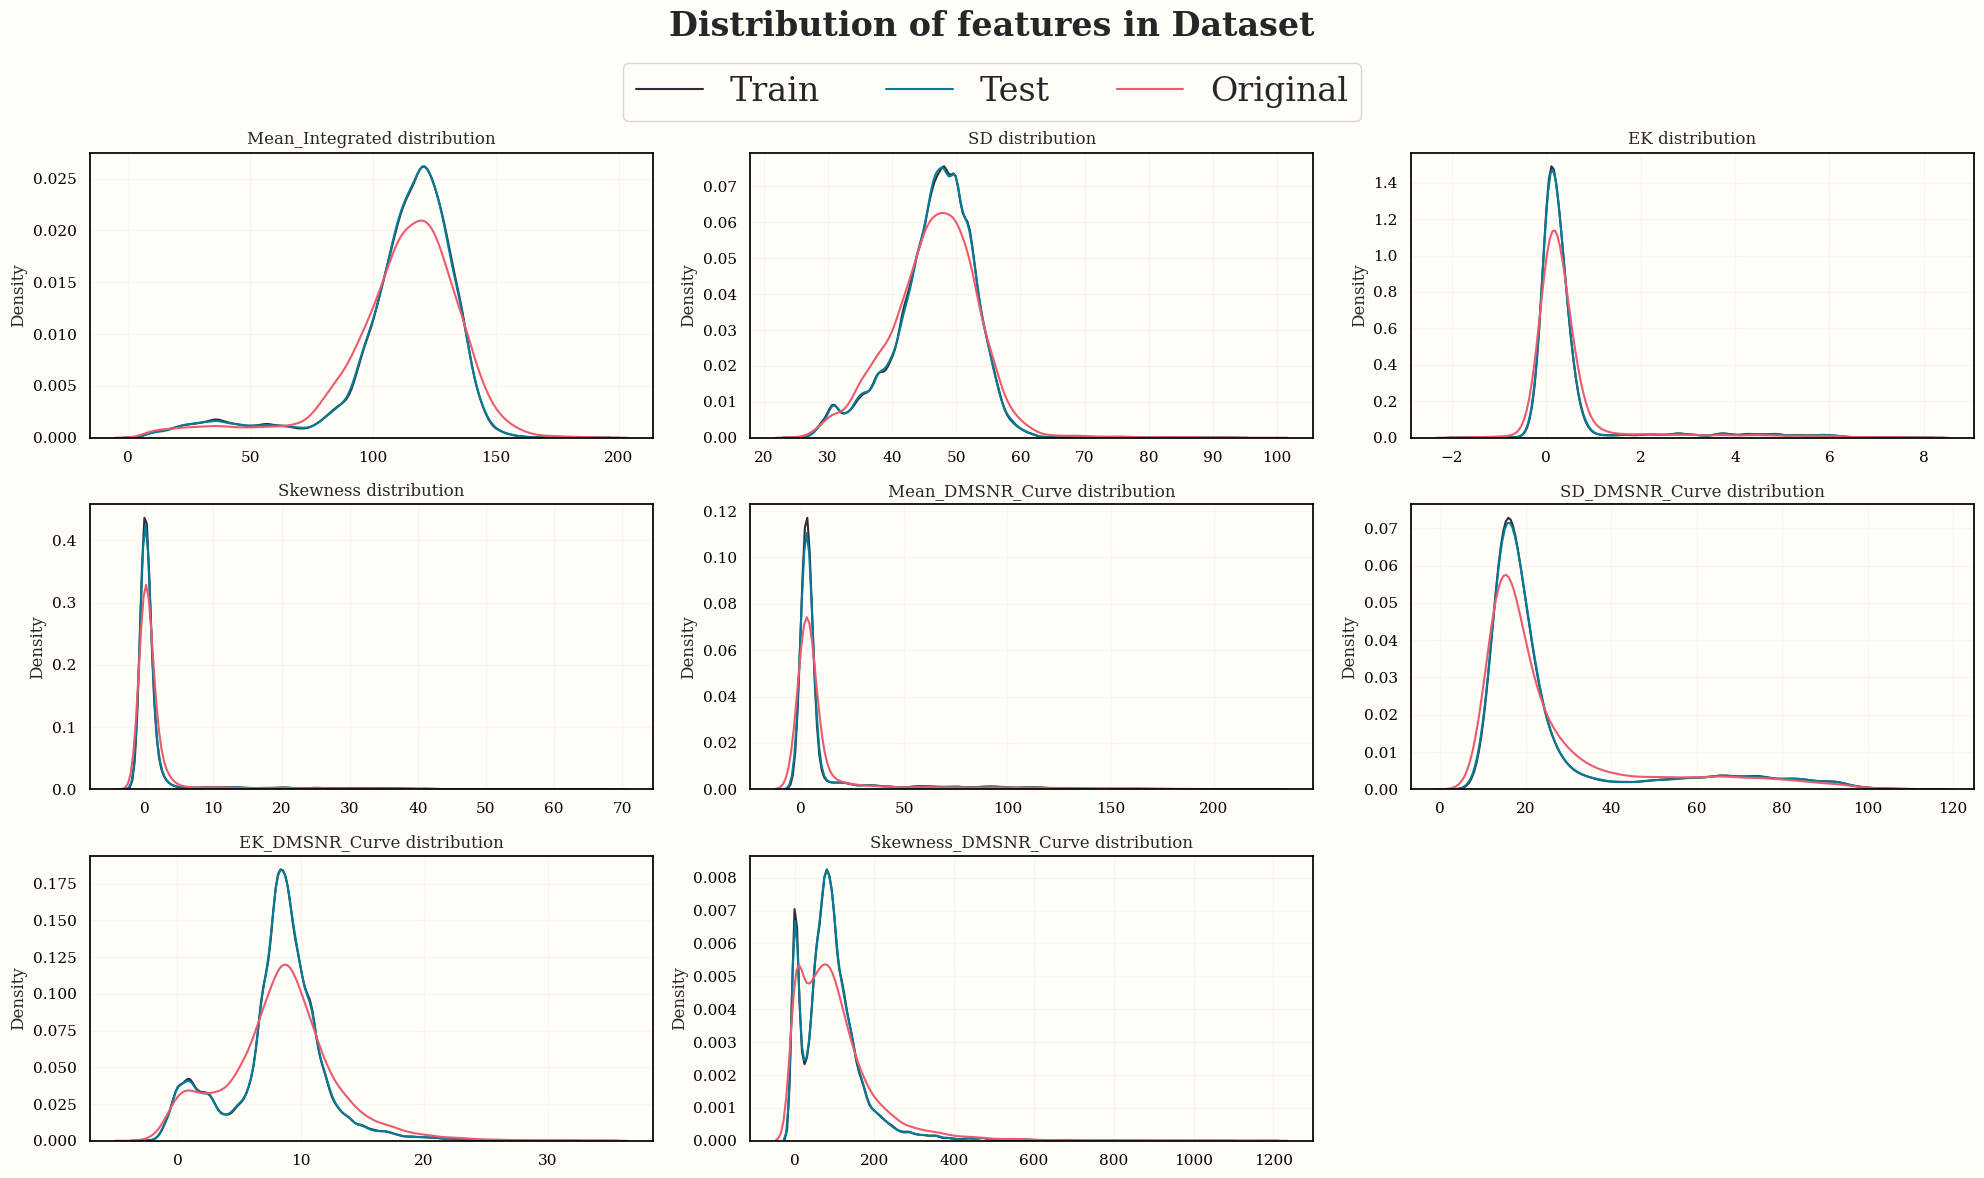

In [18]:
features = test.columns
nbins = 50
histplot_params = {
    'kde': True,
    'alpha': 0.4,
    'stat': 'percent',
    'bins': nbins
}

columns = features
ncols = 3
nrows = math.ceil(len(columns) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))

axes = axes.flatten()
for i, col in enumerate(columns):
    plot_axes = [axes[i]]
    sns.kdeplot(train[col], label='Train', ax=axes[i], color=palette[0])
    sns.kdeplot(test[col], label='Test', ax=axes[i], color=palette[1])
    sns.kdeplot(orig[col], label='Original', ax=axes[i], color=palette[-4])

    axes[i].set_title(f'{col} distribution')
    axes[i].set_xlabel('')

    handles = []
    labels = []
    for ax in plot_axes:
        handles += ax.get_legend_handles_labels()[0]
        labels += ax.get_legend_handles_labels()[1]
        ax.legend().remove()

for i in range(i+1, len(axes)):
    axes[i].axis('off')

fig.suptitle('Distribution of features in Dataset\n\n', fontsize=24, ha='center', fontweight='bold')
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=24, bbox_to_anchor=(0.5, 0.95))
plt.tight_layout()
plt.show()

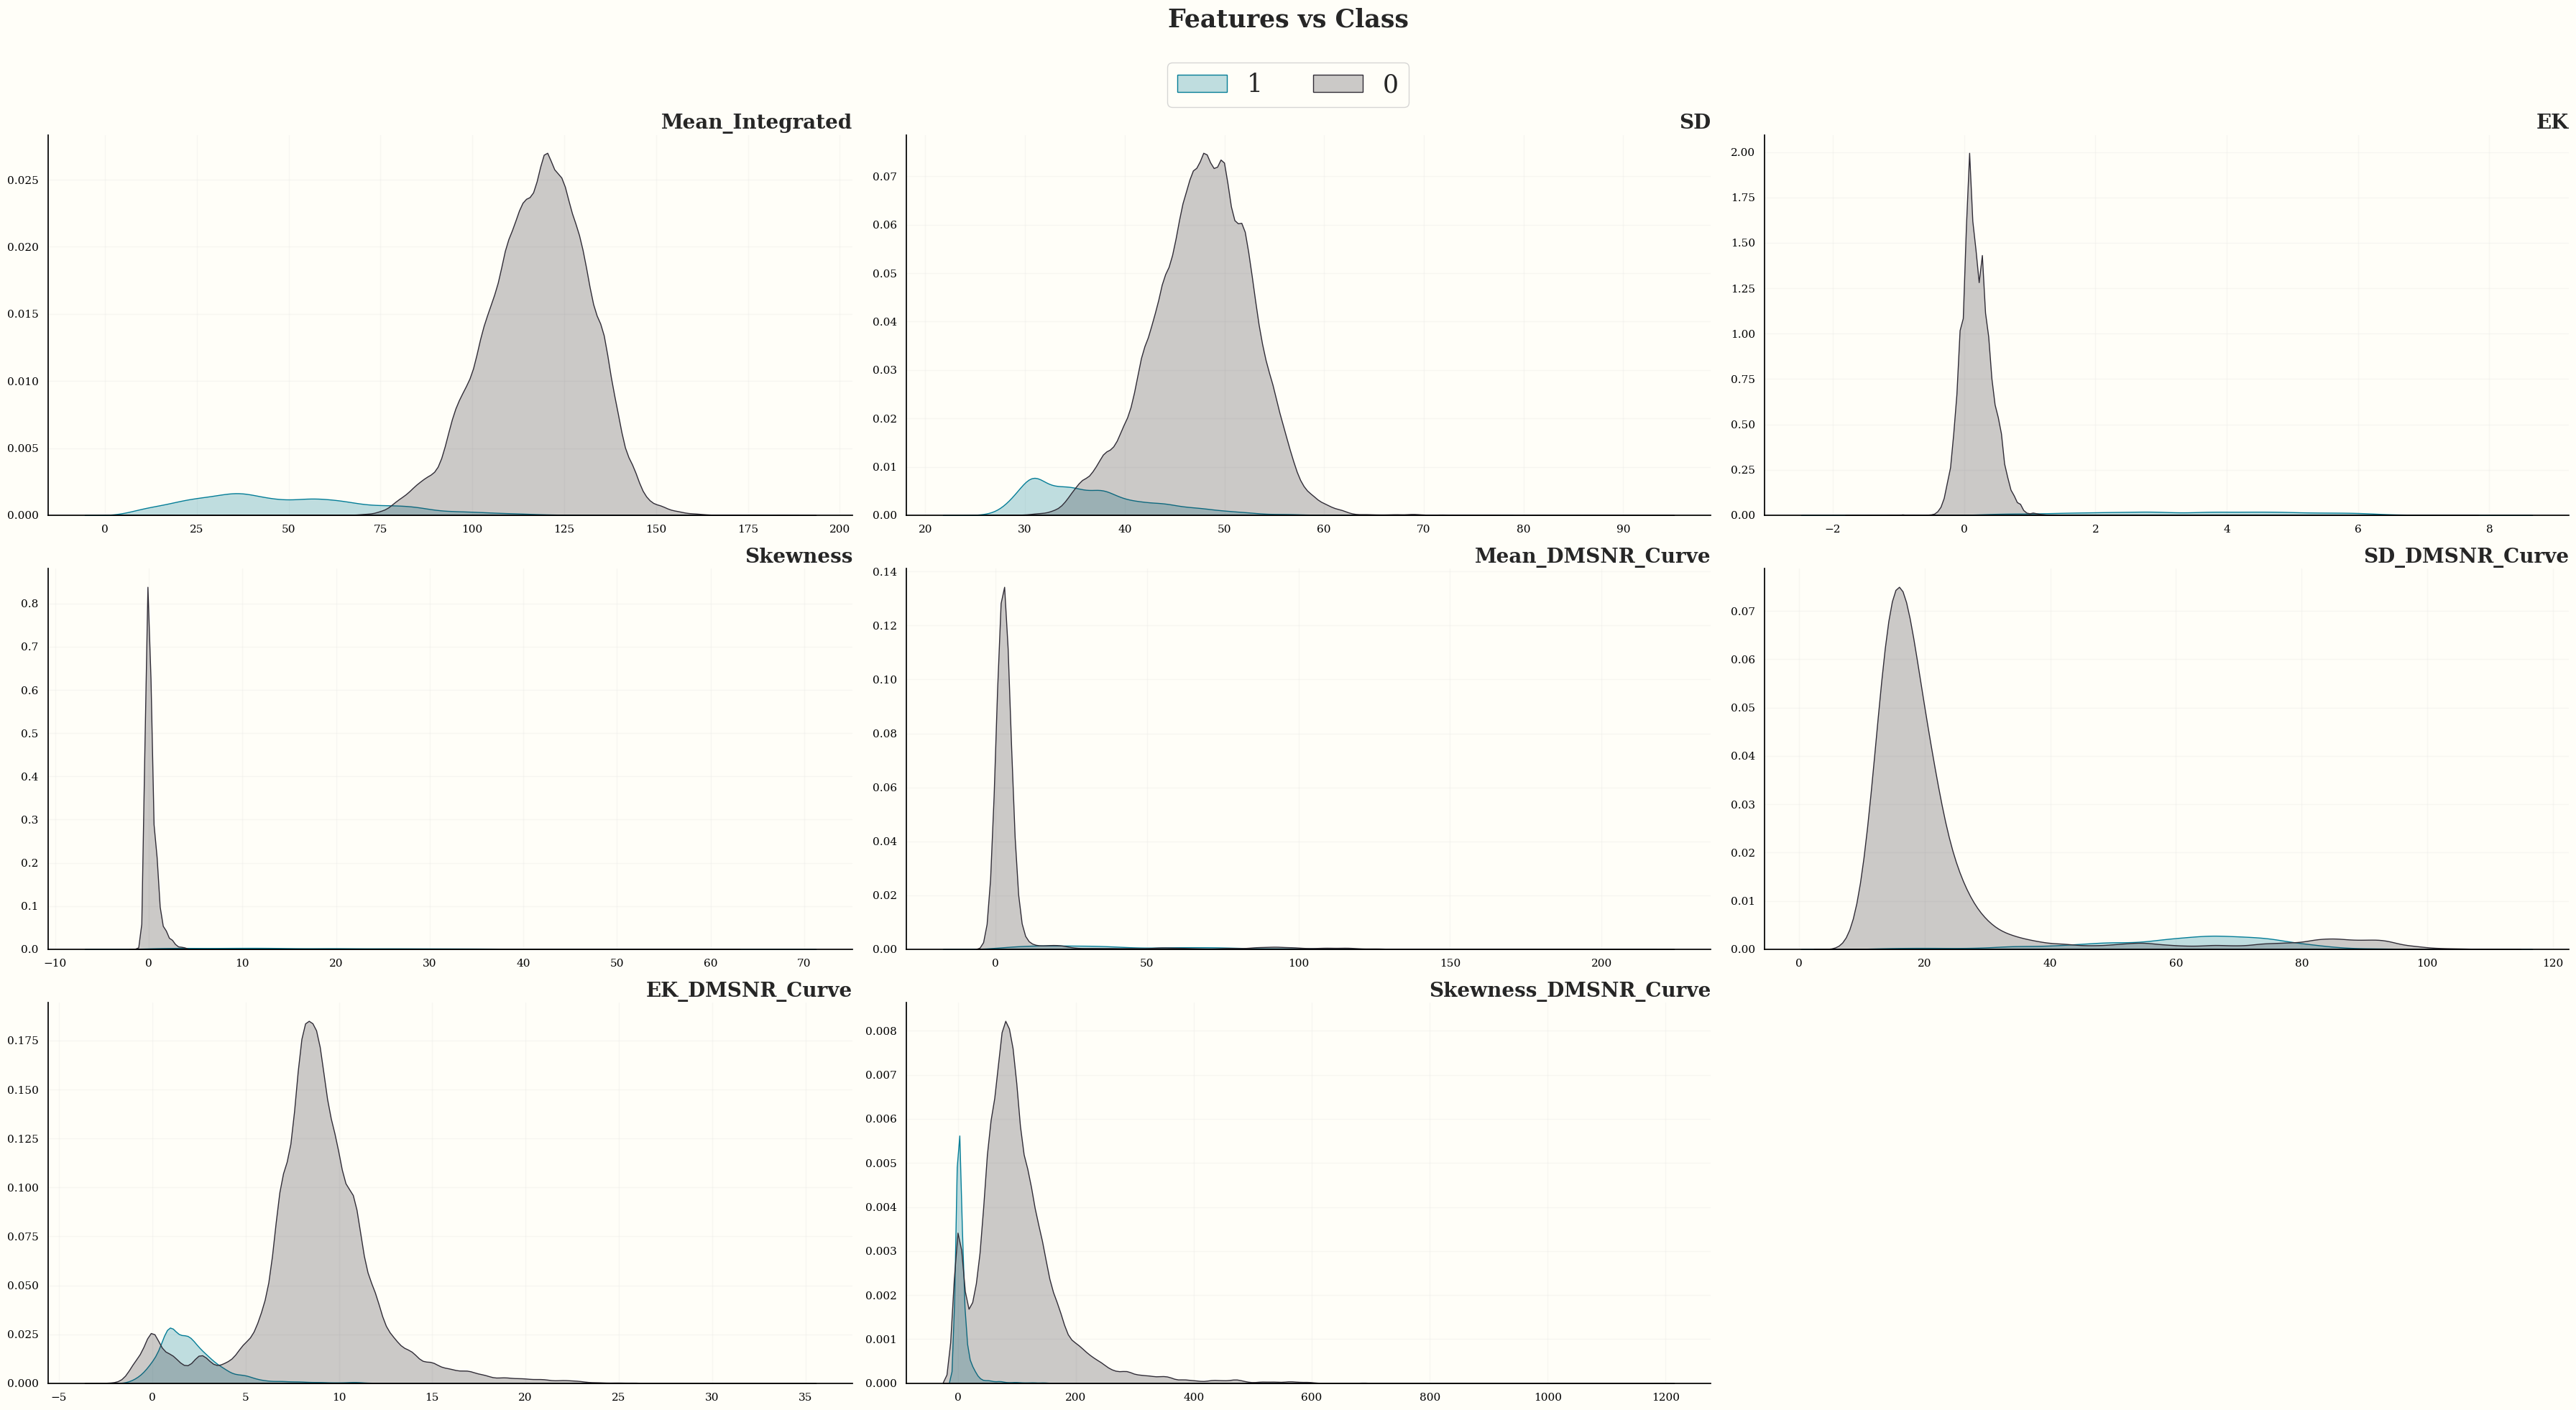

In [19]:
fig = plt.figure(figsize=(6*6, 20), dpi=100)
for idx, col in enumerate(features):
    ax = plt.subplot(3, 3, idx + 1)
    sns.kdeplot(
        data=train, hue='Class', fill=True,
        x=col, palette=palette[:2], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Class\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.95), fontsize=25, ncol=3)
plt.tight_layout()
plt.show()

# Class Imbalance

In [20]:
def plot_count(df: pd.core.frame.DataFrame, col_list: list, title_name: str='Train') -> None:
    """Draws the pie and count plots for categorical variables.
    
    Args:
        df: train or test dataframes
        col_list: a list of the selected categorical variables.
        title_name: 'Train' or 'Test' (default 'Train')
        
    Returns:
        subplots of size (len(col_list), 2)
    """
    f, ax = plt.subplots(len(col_list), 2, figsize=(10, 4))
    plt.subplots_adjust(wspace=0)
    
    s1 = df[col_list].value_counts()
    N = len(s1)

    outer_sizes = s1
    inner_sizes = s1/N

    outer_colors = [palette[0], palette[0], '#ff781f', '#ff9752', '#ff9752']
    inner_colors = [palette[1], palette[1], '#ffa66b']

    ax[0].pie(
        outer_sizes,colors=outer_colors, 
        labels=s1.index.tolist(), 
        startangle=90,frame=True, radius=1.3, 
        explode=([0.05]*(N-1) + [.3]),
        wedgeprops={ 'linewidth' : 1, 'edgecolor' : 'white'}, 
        textprops={'fontsize': 12, 'weight': 'bold'}
    )

    textprops = {
        'size':13, 
        'weight': 'bold', 
        'color':'white'
    }

    ax[0].pie(
        inner_sizes, colors=inner_colors,
        radius=1, startangle=90,
        autopct='%1.f%%',explode=([.1]*(N-1) + [.3]),
        pctdistance=0.8, textprops=textprops
    )

    center_circle = plt.Circle((0,0), .68, color='black', 
                               fc='white', linewidth=0)
    ax[0].add_artist(center_circle)

    x = s1
    y = [0, 1]
    sns.barplot(
        x=x, y=y, ax=ax[1],
        palette=palette[:2], orient='horizontal'
    )

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].tick_params(
        axis='x',         
        which='both',      
        bottom=False,      
        labelbottom=False
    )

    for i, v in enumerate(s1):
        ax[1].text(v, i+0.1, str(v), color='black', 
                     fontweight='bold', fontsize=12)

#     plt.title(col_list)
    plt.setp(ax[1].get_yticklabels(), fontweight="bold")
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    ax[1].set_xlabel(col_list, fontweight="bold", color='black')
    ax[1].set_ylabel('count', fontweight="bold", color='black')

    f.suptitle(f'{title_name} Dataset', fontsize=20, fontweight='bold')
    plt.tight_layout()    
#     plt.savefig('data/plot_count.png')
    plt.show()

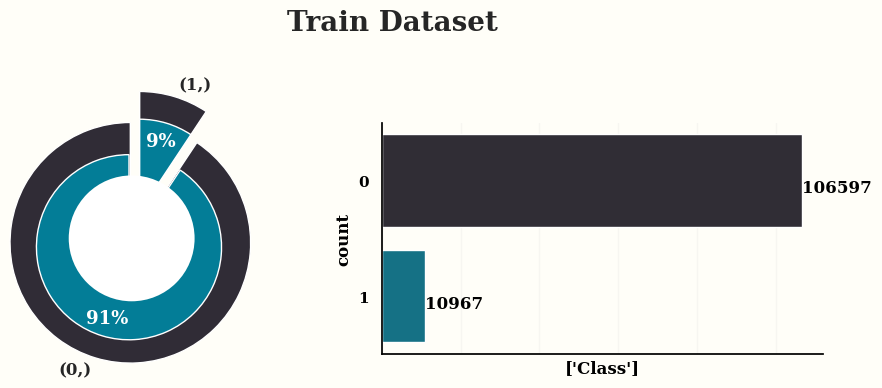

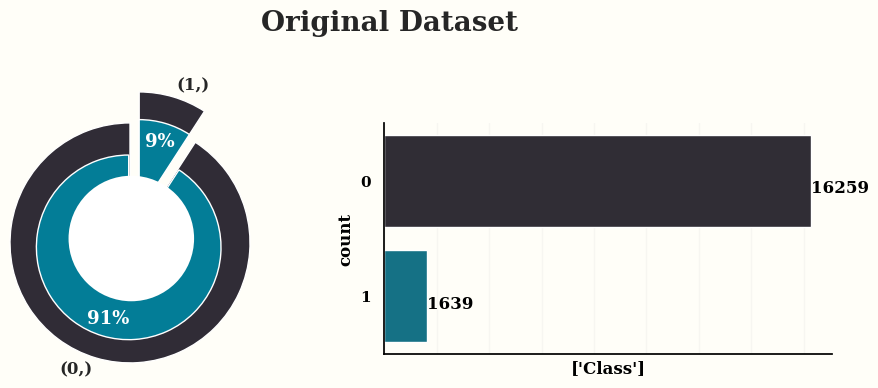

In [21]:
plot_count(train, ['Class'], 'Train')
plot_count(orig, ['Class'], 'Original')

# Correlations

In [26]:
def plot_heatmap(df: pd.core.frame.DataFrame, title: str = 'Train Correlation'):
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(10, 5))
    mask = np.triu(np.ones_like(corr))
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap=palette[5:][::-2] + palette[1:2], annot=True)
    plt.title(title)
    plt.show()

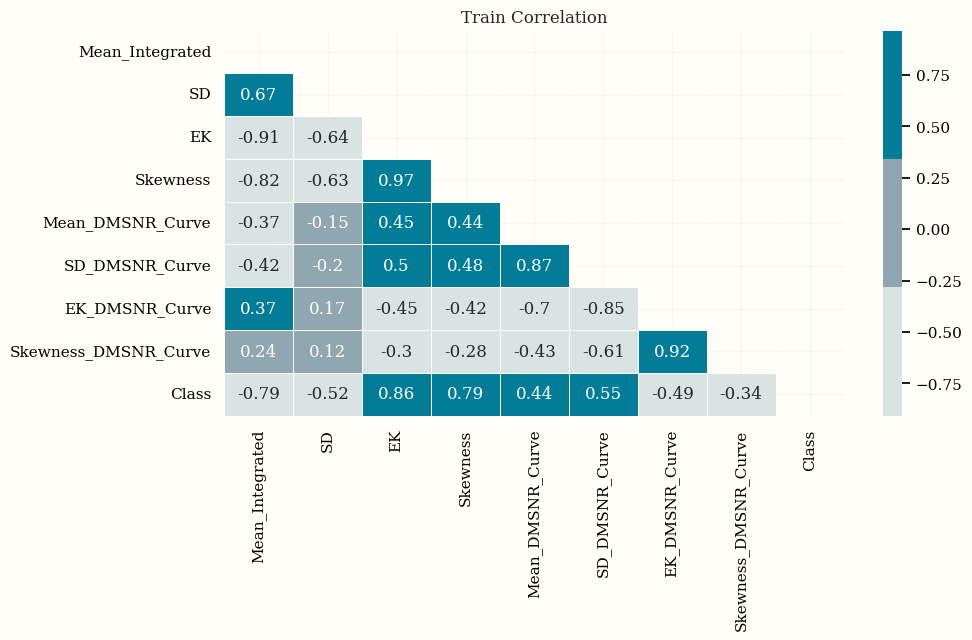

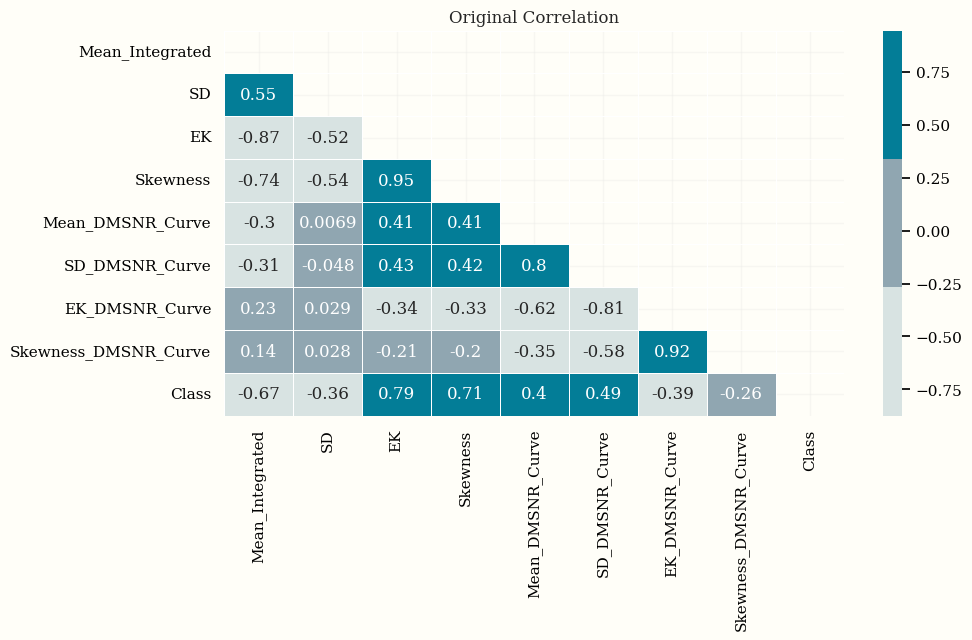

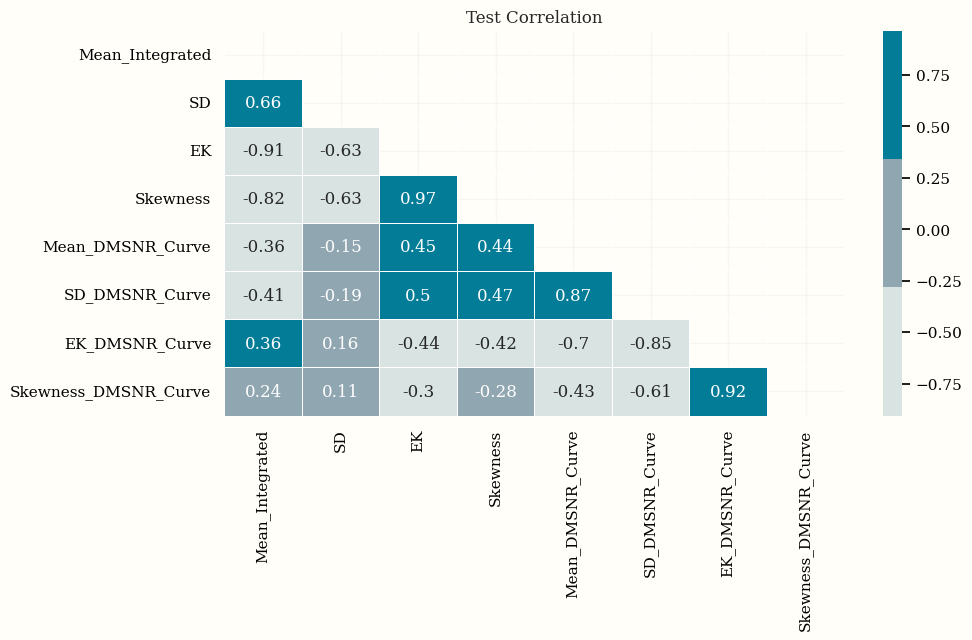

In [27]:
plot_heatmap(train, 'Train Correlation')
plot_heatmap(orig, 'Original Correlation')
plot_heatmap(test, 'Test Correlation')

In [30]:
sns.pairplot(data = train.drop(columns = ['id',], errors = 'ignore'), 
                     diag_kind = 'kde', markers= 'o', plot_kws= {'color': 'tab:blue'}, hue='Class'
                    );

- Lots of correlations!
- good chance to try filter techniques